# Эксперименты с другими моделями и различными способами подбора гиперпараметров

В ходе экспериментов были опробованы 4 модели: CatBoostClassifier, LGBMClassifier, RandomForestClassifier и XGBClassifier

Подбор гиперпараметров осуществлялся, соответственно, при помощи HyperOpt, Optuna, GridSearchCV (из sklearn) и SkOpt

Spoiler: В результате связка XGBClassifier + SkOpt смогла побить скор (public и private) LightAutoML

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [3]:
from typing import Tuple

<IPython.core.display.Javascript object>

In [4]:
import numpy as np
import pandas as pd

<IPython.core.display.Javascript object>

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

<IPython.core.display.Javascript object>

In [6]:
# https://stackoverflow.com/questions/46858373/how-to-calculate-normalized-gini-coefficient-in-tensorflow
def gini(actual, pred) -> float:
    # Подсчет gini на основе реальных и предсказанных значений
    assert len(actual) == len(pred)
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float64)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.0
    return giniSum / len(actual)


def gini_normalized(actual, pred) -> float:
    # Нормализация gini
    return gini(actual, pred) / gini(actual, actual)


def gini_normalized_score(estimator, X, y) -> float:
    # SKLearn-like обертка gini_normalized
    predicted = estimator.predict_proba(X)[:, 1] 
    score = gini_normalized(y, predicted)  
    return score

<IPython.core.display.Javascript object>

In [7]:
def int_to_str(X: pd.DataFrame) -> pd.DataFrame:
    # Преобразование всех int'ов в датафрейме в строки
    # P.S. нужно для one hot энкодинга
    X_copy = X.copy()
    return X_copy.astype(str)

<IPython.core.display.Javascript object>

In [8]:
# Загрузка данных
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

<IPython.core.display.Javascript object>

In [9]:
train_data.columns

Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],


<IPython.core.display.Javascript object>

In [10]:
# Разбиение фичей по группам для их обработки в пайплайне
numeric_features = [
    "ps_ind_01",
    "ps_ind_03",
    "ps_ind_14",
    "ps_ind_15",
    "ps_reg_01",
    "ps_reg_02",
    "ps_reg_03",
    "ps_car_11",
    "ps_car_12",
    "ps_car_13",
    "ps_car_14",
    "ps_car_15",
    "ps_calc_01",
    "ps_calc_02",
    "ps_calc_03",
    "ps_calc_04",
    "ps_calc_05",
    "ps_calc_06",
    "ps_calc_07",
    "ps_calc_08",
    "ps_calc_09",
    "ps_calc_10",
    "ps_calc_11",
    "ps_calc_12",
    "ps_calc_13",
    "ps_calc_14",
]
categorical_features = [
    "ps_ind_02_cat",
    "ps_ind_04_cat",
    "ps_ind_05_cat",
    "ps_car_01_cat",
    "ps_car_02_cat",
    "ps_car_03_cat",
    "ps_car_04_cat",
    "ps_car_05_cat",
    "ps_car_06_cat",
    "ps_car_07_cat",
    "ps_car_08_cat",
    "ps_car_09_cat",
    "ps_car_10_cat",
    "ps_car_11_cat",
]
binary_features = [
    "ps_ind_06_bin",
    "ps_ind_07_bin",
    "ps_ind_08_bin",
    "ps_ind_09_bin",
    "ps_ind_10_bin",
    "ps_ind_11_bin",
    "ps_ind_12_bin",
    "ps_ind_13_bin",
    "ps_ind_16_bin",
    "ps_ind_17_bin",
    "ps_ind_18_bin",
    "ps_calc_15_bin",
    "ps_calc_16_bin",
    "ps_calc_17_bin",
    "ps_calc_18_bin",
    "ps_calc_19_bin",
    "ps_calc_20_bin",
]

<IPython.core.display.Javascript object>

In [11]:
# Разбивка трейна на X и y
X, y = train_data.drop(["target"], axis=1), train_data.target

<IPython.core.display.Javascript object>

In [12]:
# Блоки пайплайна
# Заполнение пропусков медианой
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

# Onehot преобразование категориальных фичей
categorical_transformer = Pipeline(
    steps=[
        ("transformer", FunctionTransformer(int_to_str)),
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Единый пайплайн
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

<IPython.core.display.Javascript object>

In [13]:
def get_submission(model, X_test: pd.DataFrame) -> pd.DataFrame:
    # Получение датафрейма с предсказаниями в нужном формате
    predicts = model.predict_proba(X_test)[:, 1]
    submit = pd.DataFrame({"id": X_test.id, "target": predicts})
    return submit

<IPython.core.display.Javascript object>

## CatBoost + HyperOpt

In [14]:
from catboost import CatBoostClassifier

<IPython.core.display.Javascript object>

In [15]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

<IPython.core.display.Javascript object>

In [16]:
def fit_cb_with_hyperopt(X: pd.DataFrame, y: pd.Series) -> Tuple[Pipeline, float]:
    # Обучение CatBoost  c подбором гиперпараметров
    # с помощью HyperOpt
    def hyperopt_objective(params):
        # Objective для hyperopt (a.k.a одна итерация подбора)
        model = CatBoostClassifier(**params, verbose=0)
        pipeline = Pipeline(
            steps=[("preprocessor", preprocessor), ("classifier", model)]
        )

        score = cross_val_score(pipeline, X, y, cv=5, scoring=gini_normalized_score)
        # Приходится возвращать -score, потому что  HyperOpt не
        # умеет в максимизацию
        return {"loss": -score.mean(), "params": params, "status": STATUS_OK}

    search_space = {
        "n_estimators": hp.randint("n_estimators", 50, 1000),
        "depth": hp.randint("depth", 4, 12),
        "learning_rate": hp.uniform("learning_rate", 3e-4, 1e-1),
    }

    trials = Trials()
    best_params_cb = fmin(
        fn=hyperopt_objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=30,
        show_progressbar=True,
        trials=trials,
    )
    
    # Обучение модели с лучшими параметрами
    cb_model = CatBoostClassifier(**best_params_cb, verbose=0)
    cb_pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", cb_model)]
    )
    best_score = -min(trials.losses())

    cb_pipeline.fit(X, y)

    return cb_pipeline, best_score

<IPython.core.display.Javascript object>

In [17]:
cb_classifier, cb_best_score = fit_cb_with_hyperopt(X, y)
print("CB + HyperOpt best score:", cb_best_score)
cb_submission = get_submission(cb_classifier, test_data)

100%|███████| 30/30 [46:49<00:00, 93.65s/trial, best loss: -0.27071177517291045]
CB + HyperOpt best score: 0.27071177517291045


<IPython.core.display.Javascript object>

In [18]:
cb_submission.to_csv("cb_submit.csv", index=None)

<IPython.core.display.Javascript object>

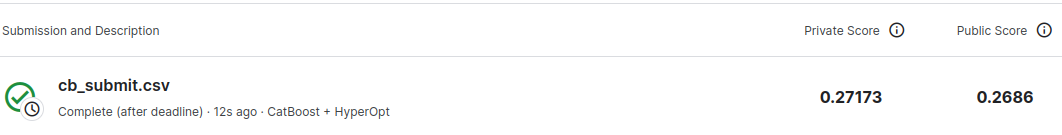

## LightGBM + Optuna

In [19]:
import optuna
from tqdm.auto import tqdm
from lightgbm import LGBMClassifier

<IPython.core.display.Javascript object>

In [21]:
class TqdmCallback:
    # Callback для вывода progress bar'а при подборе Optun'ой
    def __init__(self, total):
        self.pbar = tqdm(total=total)

    def __call__(self, study, trial):
        self.pbar.update(1)

<IPython.core.display.Javascript object>

In [20]:
def fit_lgbm_with_optuna(X: pd.DataFrame, y: pd.Series) -> Tuple[Pipeline, float]:
    # Обучение LGBM  c подбором гиперпараметров
    # с помощью Optuna
    def optuna_objective(trial):
        # Objective для optuna (a.k.a одна итерация подбора)
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
            "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 1e-1),
            "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        }

        model = LGBMClassifier(**params, n_jobs=4)
        pipeline = Pipeline(
            steps=[("preprocessor", preprocessor), ("classifier", model)]
        )

        score = cross_val_score(pipeline, X, y, cv=5, scoring=gini_normalized_score)

        return score.mean()

    tqdm_callback = TqdmCallback(30)

    study = optuna.create_study(direction="maximize")
    study.optimize(optuna_objective, n_trials=30, n_jobs=4, callbacks=[tqdm_callback])

    best_params_lgbm = study.best_trial.params
    best_score = study.best_value
    
    # Обучение модели с лучшими параметрами
    lgbm_model = LGBMClassifier(**best_params_lgbm, n_jobs=4)
    lgbm_pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", lgbm_model)]
    )

    lgbm_pipeline.fit(X, y)

    return lgbm_pipeline, best_score

<IPython.core.display.Javascript object>

In [22]:
lgbm_classifier, lgbm_best_score = fit_lgbm_with_optuna(X, y)
print("LGBM + Optuna best score:", lgbm_best_score)
lgbm_submission = get_submission(lgbm_classifier, test_data)

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-12-24 14:59:39,921] A new study created in memory with name: no-name-6cc12ce5-e74a-4a46-ba07-d68f2b343401
[I 2023-12-24 15:02:02,090] Trial 0 finished with value: 0.21788057680101852 and parameters: {'n_estimators': 369, 'learning_rate': 0.00032058095675539404, 'num_leaves': 20}. Best is trial 0 with value: 0.21788057680101852.
[I 2023-12-24 15:02:47,339] Trial 3 finished with value: 0.24615218705660874 and parameters: {'n_estimators': 377, 'learning_rate': 0.0024808877146407526, 'num_leaves': 86}. Best is trial 3 with value: 0.24615218705660874.
[I 2023-12-24 15:03:25,685] Trial 1 finished with value: 0.233551252347117 and parameters: {'n_estimators': 977, 'learning_rate': 0.042305177760975296, 'num_leaves': 89}. Best is trial 3 with value: 0.24615218705660874.
[I 2023-12-24 15:05:06,146] Trial 2 finished with value: 0.23870451821674243 and parameters: {'n_estimators': 836, 'learning_rate': 0.0007060841215435209, 'num_leaves': 52}. Best is trial 3 with value: 0.246152187056608

LGBM + Optuna best score: 0.26784086700496285


<IPython.core.display.Javascript object>

In [23]:
lgbm_submission.to_csv("lgbm_submit.csv", index=None)

<IPython.core.display.Javascript object>

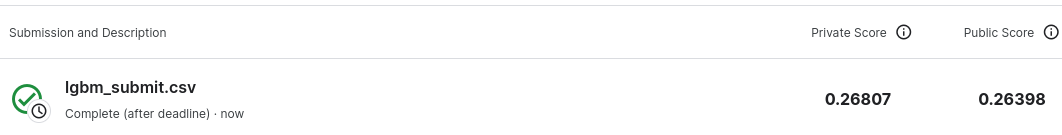

## RFClassifier + GridSearchCV

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

<IPython.core.display.Javascript object>

In [25]:
def fit_rf_with_gridsearchcv(X: pd.DataFrame, y: pd.Series) -> Tuple[Pipeline, float]:
    # Обучение RandomForest c подбором гиперпараметров
    # с помощью GridSearchCV
    param_grid = {
        "classifier__max_depth": [6, 8, 10],
        "classifier__n_estimators": [200, 300, 400],
    }

    model = RandomForestClassifier(verbose=0, n_jobs=4)
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])
    rf_grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, n_jobs=4, scoring=gini_normalized_score, verbose=3
    )

    rf_grid_search.fit(X, y)
    best_score = rf_grid_search.best_score_

    return rf_grid_search.best_estimator_, best_score

<IPython.core.display.Javascript object>

In [26]:
rf_classifier, rf_best_score = fit_rf_with_gridsearchcv(X, y)
print("RF + GridSearchCV best score:", rf_best_score)
rf_submission = get_submission(rf_classifier, test_data)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
RF + GridSearchCV best score: 0.24909202665760496


<IPython.core.display.Javascript object>

In [27]:
rf_submission.to_csv("rf_submit.csv", index=None)

<IPython.core.display.Javascript object>

[CV 3/5] END classifier__max_depth=6, classifier__n_estimators=200;, score=0.245 total time= 1.6min
[CV 3/5] END classifier__max_depth=6, classifier__n_estimators=300;, score=0.245 total time= 2.3min
[CV 1/5] END classifier__max_depth=6, classifier__n_estimators=400;, score=0.240 total time= 3.0min
[CV 1/5] END classifier__max_depth=8, classifier__n_estimators=200;, score=0.245 total time= 2.5min
[CV 4/5] END classifier__max_depth=8, classifier__n_estimators=200;, score=0.239 total time= 2.4min
[CV 3/5] END classifier__max_depth=8, classifier__n_estimators=300;, score=0.250 total time= 3.6min
[CV 2/5] END classifier__max_depth=8, classifier__n_estimators=400;, score=0.241 total time= 4.6min
[CV 1/5] END classifier__max_depth=10, classifier__n_estimators=200;, score=0.248 total time= 3.8min
[CV 4/5] END classifier__max_depth=10, classifier__n_estimators=200;, score=0.244 total time= 3.5min
[CV 3/5] END classifier__max_depth=10, classifier__n_estimators=300;, score=0.255 total time= 5.3m

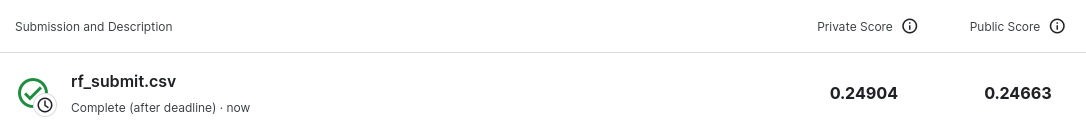

## XGBoost + SkOpt

In [33]:
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real

<IPython.core.display.Javascript object>

In [38]:
def fit_xgboost_with_skopt(X: pd.DataFrame, y: pd.Series) -> Tuple[Pipeline, float]:
    # Обучение XBGoost c подбором гиперпараметров
    # с помощью SkOpt
    
    search_space = {
        'learning_rate': Real(0.01, 1.0, prior='log-uniform'),
        'min_child_weight': Real(1, 20),
        'subsample': Real(0.5, 1.0, prior='uniform'),
        'colsample_bytree': Real(0.5, 1.0, prior='uniform')
    }
    # P.s. можно было перебрать большее количество гиперпараметров
    # Но SkOpt использует устаревший numpy и попытка передать integer
    # параметры заканчивается падением ячейки. Поэтому целочисленные
    # значения были выбраны "по ощущениям"
    model = XGBClassifier(n_estimators = 500, max_depth = 10)
    
    bayes_search_cv = BayesSearchCV(
        model, 
        search_space, 
        n_iter=30,
        cv=5,
        scoring=gini_normalized_score,
        verbose=1
    )
    
    bayes_search_cv.fit(X, y)
    best_score = bayes_search_cv.best_score_
    
    return bayes_search_cv.best_estimator_, best_score


<IPython.core.display.Javascript object>

In [39]:
xgb_classifier, xgb_best_score = fit_xgboost_with_skopt(X, y)
print("XGBoost + SkOpt best score:", xgb_best_score)
xgb_submission = get_submission(xgb_classifier, test_data)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

<IPython.core.display.Javascript object>

In [40]:
xgb_submission.to_csv("xgb_submit.csv", index=None)

<IPython.core.display.Javascript object>

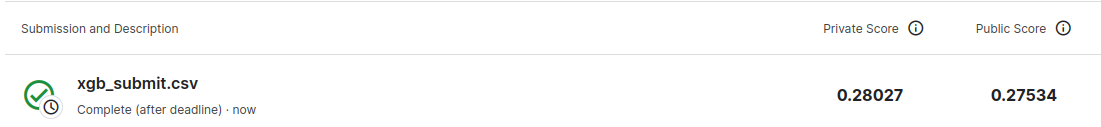

### Profit - скор ламы пробит